# HH model in ANNarchy

When I first encounter [ANNarchy](https://annarchy.readthedocs.io), I am 
exciting and feel happy, because ANNarchy is much more easy-to-use than [Brian2](https://brian2.readthedocs.io/).
However, one day I want to implement a complex Hodgkin-Huxley-like conductance neuron model,
I tried my best and cannot get what I want. 

I gradually knew this is the bug of ANNarchy for Hodgkin-Huxley implementation. 
And more sadly, although I knew it is wrong, I cannot fix it. All the things seem to be right,
but I don't know what's wrong. 

In the next, I will show the bugs of `Hodgkin-Huxley model` provided by ANNarchy official 
[examples](https://annarchy.readthedocs.io/en/latest/example/HodgkinHuxley.html).

First, let's import the library, and define the visualzation functions.

In [1]:
import sys
from ANNarchy import *
import matplotlib.pyplot as plt

ANNarchy 4.6 (4.6.8.1) on linux (posix). 


In [2]:
def show_mon(ts, mon):
    data = mon.get()
    plt.subplot(2, 2, 1)
    plt.plot(ts, data['V'][:, 0])
    plt.title('V')
    plt.subplot(2, 2, 2)
    plt.plot(ts, data['n'][:, 0])
    plt.title('n')
    plt.ylim((0.0, 1.0))
    plt.subplot(2, 2, 3)
    plt.plot(ts, data['m'][:, 0])
    plt.title('m')
    plt.ylim((0.0, 1.0))
    plt.subplot(2, 2, 4)
    plt.plot(ts, data['h'][:, 0])
    plt.title('h')
    plt.ylim((0.0, 1.0))
    plt.show()

Then, let's define the running function of the model.

In [3]:
def run_model(Iext):
    dt = 0.01
    setup(dt=dt)

    HH = Neuron(
        parameters="""
        C = 1.0 # Capacitance
        VL = -59.387 # Leak voltage
        VK = -82.0 # Potassium reversal voltage
        VNa = 45.0 # Sodium reveral voltage
        gK = 36.0 # Maximal Potassium conductance
        gNa = 120.0 # Maximal Sodium conductance
        gL = 0.3 # Leak conductance
        vt = 30.0 # Threshold for spike emission
        I = 0.0 # External current
        """,

        equations="""
        # Previous membrane potential
        prev_V = V

        # Voltage-dependency parameters
        an = 0.01 * (V + 60.0) / (1.0 - exp(-0.1* (V + 60.0) ) )
        am = 0.1 * (V + 45.0) / (1.0 - exp (- 0.1 * ( V + 45.0 )))
        ah = 0.07 * exp(- 0.05 * ( V + 70.0 ))

        bn = 0.125 * exp (- 0.0125 * (V + 70.0))
        bm = 4.0 *  exp (- (V + 70.0) / 80.0)
        bh = 1.0/(1.0 + exp (- 0.1 * ( V + 40.0 )) )

        # Alpha/Beta functions
        dn/dt = an * (1.0 - n) - bn * n : init = 0.3, midpoint
        dm/dt = am * (1.0 - m) - bm * m : init = 0.0, midpoint
        dh/dt = ah * (1.0 - h) - bh * h : init = 0.6, midpoint

        # Membrane equation
        C * dV/dt = gL * (VL - V ) + gK * n**4 * (VK - V) + gNa * m**3 * h * (VNa - V) + I : midpoint

        """,

        spike="""
        # Spike is emitted when the membrane potential crosses the threshold from below
        (V > vt) and (prev_V <= vt)    
        """,

        reset="""
        # Nothing to do, it is built-in...
        """
    )

    pop = Population(neuron=HH, geometry=1)
    pop.V = -50.0

    compile(clean=True)

    m = Monitor(pop, ['spike', 'V', 'n', 'm', 'h'])

    duration = sum([d for _, d in Iext])

    for I, dur in Iext:
        pop.I = I
        simulate(dur)

    ts = np.arange(0, duration, dt)
    show_mon(ts, m)

The official example provide the external inputs like this:
- The first 100 ms, warm up the model;
- The next 1 ms, provide the curren `I=200.0`;
- Final 100 ms, no external inputs.

The results are shown as in the following.

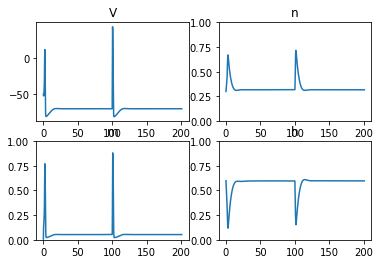

In [4]:
run_model([(0., 100.), (200., 1.), (0., 100.)])

However, when we sightly change the external inputs. For example, provide
the current `I=200.0` with the length of `101 ms`. We would expect that the model
will produce repetive firing. However, the actual running results

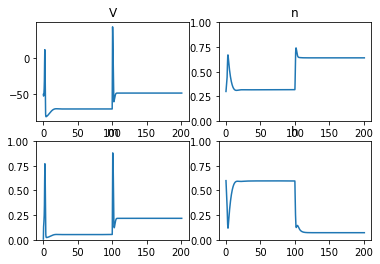

In [4]:
run_model([(0., 100.), (200., 101.)])

So, how can I fix the wrong scripts? 

All the things seems right, what is wrong?

How can I/you do?